# Adversarial Learning

![street fighter](assets/adversarial/street_fighter.jpg)

(image: https://www.flickr.com/photos/sbfisher/856125311, [Creative Commons License](https://creativecommons.org/licenses/by-nc-sa/2.0/))

# Topics

- Adversarial examples
- Generative Adversarial Networks

# Adversarial Examples

Data inputs that fool neural networks, but not people

![example](assets/adversarial/adversarial_example.png)

(image: [Deep Learning](http://www.deeplearningbook.org/contents/regularization.html), Ian Goodfellow and Yoshua Bengio and Aaron Courville)

## Walkthrough - Adversarial Examples

In this walkthrough, we will see how a Neural Network handles adversarial examples.

1. Get predictions for an image
2. Convert image to an adversarial example
3. Re-evaluate the adversarial example

### Setup - Install Foolbox

Foolbox is a Python toolbox to create adversarial examples that fool neural networks.

https://github.com/bethgelab/foolbox

```
pip install foolbox
```

In [79]:
def resize_and_crop_image(image_path, width, height):
    """Resizes and crops an image to the desired size
    Args:
        image_path: path to the image
        width: image width
        height: image height
    Returns:
        the resulting image
    """
    from PIL import Image, ImageOps
    
    img = Image.open(image_path)
    img = ImageOps.fit(img, (width, height))
    return img

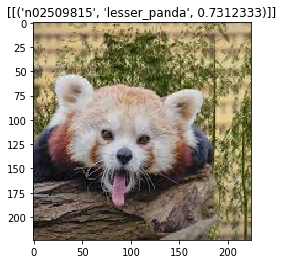

In [113]:
# 1. Get predictions for an image
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import img_to_array

import matplotlib.pyplot as plt
import numpy as np

model = ResNet50()
width = height = 224

image_path = './assets/adversarial/panda.jpg'

img = resize_and_crop_image(image_path, width, height)
plt.imshow(img)

x = img_to_array(img)
x = preprocess_input(x)
x = np.expand_dims(x, axis=0)
y = model.predict(x)
preds = decode_predictions(y, top=1)
plt.title(preds)
plt.axis('off')
plt.show()

In [ ]:
from keras.backend import set_learning_phase
from PIL import Image
import foolbox

# Example from: https://github.com/bethgelab/foolbox
set_learning_phase(0) # not training
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = foolbox.models.KerasModel(ResNet50(), bounds=(0, 255),
                                   preprocessing=preprocessing)

# Apply attack on source image to target a different label
attack = foolbox.attacks.FGSM(model=fmodel)

# labels from Keras
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
label = 387 # lesser panda

x = resize_and_crop_image(image_path, width, height)
x = np.asarray(x, dtype=np.float32)
x = x[:, :, :3]

adversarial = attack(x[:, :, ::-1], label)
adversarial = preprocess_input(adversarial)
y = model.predict(np.expand_dims(adversarial, axis=0))
preds = decode_predictions(y, top=1)

plt.imshow(adversarial)
plt.title(preds)
plt.axis('off')
plt.show()

## Optional Exercise

Try other attacks available in Foolbox
- https://foolbox.readthedocs.io/en/latest/modules/attacks.html

## Generative Adversarial Networks (GANs)

- Train two networks against each other
- Generator: generates fake images to fool Discriminator
- Discriminator: tries to distinguish real images from fake ones

## Generator
![generator](assets/adversarial/generator.png)

(image: https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0)

## Discriminator
![discriminator](assets/adversarial/discriminator.png)

(image: https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0)

## Examples

https://github.com/eriklindernoren/Keras-GAN

https://github.com/eriklindernoren/PyTorch-GAN

## Workshop: Training a GAN

Credits: https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87

In [107]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

In [ ]:
width = height = 28
channels = 1
shape = (width, height, channels)

In [ ]:
def generator():
    """Returns a generator model"""
    model = Sequential()
    model.add(Dense(256, input_shape=(100,)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(height * height * channels, activation='tanh'))
    model.add(Reshape((width, height, channels)))
    return model

In [ ]:
def discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=shape))
    model.add(Dense((width * height * channels), input_shape=shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense((width * height * channels)/2))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

## Adversarial Model

The adversarial model is created by chaining the generator with the discriminator.

1. Input goes into the Generator, which tries to make it fake
2. The output from the Generator will be fed into the Discriminator, which tries to discriminate the fake images from real ones.

![adversarial model](assets/adversarial/adversarial_model.png)

(image: https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0)

## Exercise - Create Adversarial Model

Create our stacked adversarial model as shown in the picture above.

Steps
1. Create and compile the generator with `binary_crossentropy` loss and `Adam(lr=0.0002, decay=8e-9)` optimizer

2. Create and compile the discriminator with `binary_crossentropy` loss and `Adam(lr=0.0002, decay=8e-9)` optimizer

3. Chain the two into a `Sequential()` adversarial model, and compile it.
  - For the adversarial model, the discriminator's weights should be frozen.

You can refer to https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87 if you are stuck.

In [111]:
# Your code here
opt = Adam(lr=0.0002, decay=8e-9)
loss = 'binary_crossentropy'

gen = generator()
gen.compile(loss=loss, optimizer=opt)

dis = discriminator()
dis.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

# Adversarial model
gan = Sequential()
dis.trainable = False # freeze weights
gan.add(gen) # generator messes with the input
gan.add(dis) # discriminator tries not to get fooled
gan.compile(loss=loss, optimizer=opt)

NameError: name 'generator' is not defined

## Train the GAN
 
![training](assets/adversarial/training.png)

(image: https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0)

In [ ]:
def plot_images(samples=16, step=0):
    """Plots the generated images at the given step
    Args:
        samples: number of images to generate
        step: step count
    """
    import matplotlib.pyplot as plt

    noise = np.random.normal(0, 1, (samples,100))
    images = gen.predict(noise)
        
    plt.figure(figsize=(10,10))
    
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

In [ ]:
epochs = 20000
batch = 32
save_interval = 200

for cnt in range(epochs):

    # Get real images
    random_index =  np.random.randint(0, len(X_train) - batch/2)
    legit_images = X_train[random_index : random_index + batch/2].reshape(batch/2, width, height, channels)

    # Have the generator predict fake images
    gen_noise = np.random.normal(0, 1, (batch/2,100))
    synthetic_images = gen.predict(gen_noise)
    x_combined_batch = np.concatenate((legit_images, synthetic_images))
    y_combined_batch = np.concatenate((np.ones((batch/2, 1)), np.zeros((batch/2, 1))))

    # Train the discriminator with the fake images and the real images
    dis_loss = dis.train_on_batch(x_combined_batch, y_combined_batch)

    # Train the generator (which is embedded in the Adversarial network)
    # For the Adversarial network, the discriminator weights are frozen.
    noise = np.random.normal(0, 1, (batch,100))
    y_mislabeled = np.ones((batch, 1))
    gan_loss = gan.train_on_batch(noise, y_mislabeled)
    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, dis_loss[0], gan_loss))

    # show progress
    if cnt % save_interval == 0 : 
        plot_images(step=cnt)

## Reading List

|Material|Read it for|URL|
|--|--|--|
|Section 7.13 Adversarial Training (Pages 265-266)|How to improve network robustness with adversarial examples|http://www.deeplearningbook.org/contents/regularization.html|
|Section 7.13 Generative Adversarial Networks (Pages 696-699|A short introduction on GANs (motivation, challenges)|http://www.deeplearningbook.org/contents/generative_models.html|
